In [1]:
from __future__ import print_function
from __future__ import division
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import time
import os
import copy
import pickle
import numpy as np
import pandas as pd

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2
CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi
torch.cuda.empty_cache()
torch.cuda.is_available()

Mon Dec 30 22:07:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P5    N/A /  N/A |    211MiB /  4040MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

In [ ]:
# Датасет несбалансирван по классам
# Для классов, которых меньше - размножим датасет
# Дальше для копий также будут применяться рандомные трансофмации
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/disco_stu/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/martin_prince/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/miss_hoover/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/nelson_muntz/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/otto_mann/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/rainier_wolfcastle/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/sideshow_mel/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/snake_jailbird/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/troy_mcclure/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/patty_bouvier/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/selma_bouvier/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/barney_gumble/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/professor_john_frink/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/gil/*.jpg; do cp "$i" "${i%.*}1.jpg"; done
# for i in /storage/Study/neuro/simpsons/train/simpsons_dataset/carl_carlson/*.jpg; do cp "$i" "${i%.*}1.jpg"; done


In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
# При загрузке данных в режиме train добавлены случайные трансформации
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):

        if self.mode == 'test':
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        elif self.mode == 'val':
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        elif self.mode == 'train':
          transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(degrees = 20),
              transforms.RandomRotation(degrees = 20),
              transforms.RandomRotation(degrees = 10),
              transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.7, 1.0)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
          
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
# Пути до датасетов изменены в соответвии с локальными
TRAIN_DIR = Path('/storage/Study/neuro/simpsons/train/simpsons_dataset/')
TEST_DIR = Path('/storage/Study/neuro/simpsons/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')
# чтобы посмотреть на трансформированые картинки загрузить в режиме train,
# но не забыть вернуть обратно
# val_dataset = SimpsonsDataset(val_files, mode='train') 

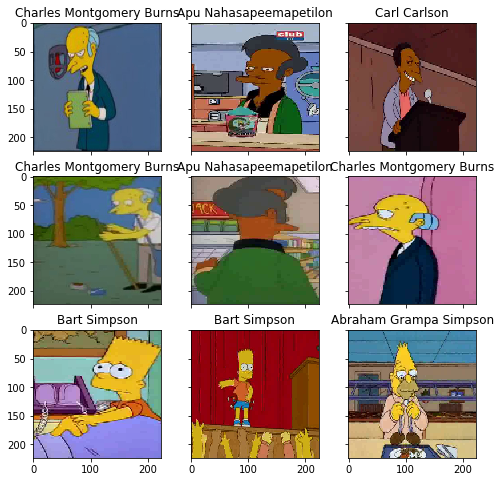

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [11]:
# Для ResNet учим слой класификатора и последний сверточный слой layer4 
def set_parameter_requires_grad(model):
    
  for param in model.parameters():
      param.requires_grad = False
        
  for param in model.layer4.parameters():
      param.requires_grad = True
        

In [12]:
# используем предобученную ResNet50
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.model_ft = models.resnet50(pretrained=True)
        set_parameter_requires_grad(self.model_ft)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, num_ftrs)

    def forward(self, x):
        logits = self.model_ft(x)
        return logits



In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [44]:
# Используем подобранный StepLR
# Оптимизатор AdamW
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.02)
        scheduler = StepLR(opt, step_size=2, gamma=0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            scheduler.step()
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [43]:
n_classes = len(np.unique(train_val_labels))
classes_number = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))

# убедимся что не напутали с размерностями и архитектурой
print(simple_cnn)

we will classify :42
SimpleCnn(
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample)

In [18]:
# убедимся что учим те слои, которые хотим
params_to_update = simple_cnn.parameters()
print("Params to learn:")

params_to_update = []
for name,param in simple_cnn.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 model_ft.layer4.0.conv1.weight
	 model_ft.layer4.0.bn1.weight
	 model_ft.layer4.0.bn1.bias
	 model_ft.layer4.0.conv2.weight
	 model_ft.layer4.0.bn2.weight
	 model_ft.layer4.0.bn2.bias
	 model_ft.layer4.0.conv3.weight
	 model_ft.layer4.0.bn3.weight
	 model_ft.layer4.0.bn3.bias
	 model_ft.layer4.0.downsample.0.weight
	 model_ft.layer4.0.downsample.1.weight
	 model_ft.layer4.0.downsample.1.bias
	 model_ft.layer4.1.conv1.weight
	 model_ft.layer4.1.bn1.weight
	 model_ft.layer4.1.bn1.bias
	 model_ft.layer4.1.conv2.weight
	 model_ft.layer4.1.bn2.weight
	 model_ft.layer4.1.bn2.bias
	 model_ft.layer4.1.conv3.weight
	 model_ft.layer4.1.bn3.weight
	 model_ft.layer4.1.bn3.bias
	 model_ft.layer4.2.conv1.weight
	 model_ft.layer4.2.bn1.weight
	 model_ft.layer4.2.bn1.bias
	 model_ft.layer4.2.conv2.weight
	 model_ft.layer4.2.bn2.weight
	 model_ft.layer4.2.bn2.bias
	 model_ft.layer4.2.conv3.weight
	 model_ft.layer4.2.bn3.weight
	 model_ft.layer4.2.bn3.bias
	 model_ft.fc.weight
	 model

Запустим обучение сети.

In [45]:
  train_val_labels = [path.parent.name for path in train_val_files]
  train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
  val_dataset = SimpsonsDataset(val_files, mode='val')
  train_dataset = SimpsonsDataset(train_files, mode='train')

In [20]:
# загрузим полученные ранее веса и продолжаем обучение
# simple_cnn.load_state_dict(torch.load("/storage/Study/neuro/weightsresnet50_16_2.whts"), strict=False)

<All keys matched successfully>

In [46]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64) 

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.848256188850493


epoch:  10%|█         | 1/10 [05:12<46:53, 312.58s/it]


Epoch 001 train_loss: 1.8483     val_loss 0.7651 train_acc 0.5313 val_acc 0.7952
loss 0.8281153820658111


epoch:  20%|██        | 2/10 [10:18<41:25, 310.64s/it]


Epoch 002 train_loss: 0.8281     val_loss 0.5107 train_acc 0.7782 val_acc 0.8614
loss 0.38604403228235595


epoch:  30%|███       | 3/10 [15:24<36:05, 309.31s/it]


Epoch 003 train_loss: 0.3860     val_loss 0.3749 train_acc 0.8973 val_acc 0.9008
loss 0.3195361530646178


epoch:  40%|████      | 4/10 [20:30<30:48, 308.12s/it]


Epoch 004 train_loss: 0.3195     val_loss 0.3824 train_acc 0.9128 val_acc 0.8987
loss 0.23518224781083025


epoch:  50%|█████     | 5/10 [25:36<25:37, 307.44s/it]


Epoch 005 train_loss: 0.2352     val_loss 0.2992 train_acc 0.9348 val_acc 0.9240
loss 0.20650688225800812


epoch:  60%|██████    | 6/10 [30:41<20:27, 306.88s/it]


Epoch 006 train_loss: 0.2065     val_loss 0.2605 train_acc 0.9428 val_acc 0.9376
loss 0.16202898313577202


epoch:  70%|███████   | 7/10 [35:47<15:19, 306.53s/it]


Epoch 007 train_loss: 0.1620     val_loss 0.2164 train_acc 0.9565 val_acc 0.9499
loss 0.14800830066466775


epoch:  80%|████████  | 8/10 [40:53<10:12, 306.45s/it]


Epoch 008 train_loss: 0.1480     val_loss 0.2163 train_acc 0.9596 val_acc 0.9499
loss 0.13248968480155596


epoch:  90%|█████████ | 9/10 [45:59<05:06, 306.28s/it]


Epoch 009 train_loss: 0.1325     val_loss 0.2037 train_acc 0.9647 val_acc 0.9544
loss 0.13025283807980756


epoch: 100%|██████████| 10/10 [51:07<00:00, 306.66s/it]


Epoch 010 train_loss: 0.1303     val_loss 0.2211 train_acc 0.9641 val_acc 0.9459


In [35]:
# Получили неплохой acc, далее можно дообучаться варируя LR
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.002)
        scheduler = StepLR(opt, step_size=2, gamma=0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            scheduler.step()
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [36]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.1605762464663479


epoch:  10%|█         | 1/10 [05:05<45:53, 305.90s/it]


Epoch 001 train_loss: 0.1606     val_loss 0.2176 train_acc 0.9560 val_acc 0.9442
loss 0.15739153201680056


epoch:  20%|██        | 2/10 [10:12<40:47, 305.98s/it]


Epoch 002 train_loss: 0.1574     val_loss 0.2113 train_acc 0.9578 val_acc 0.9466
loss 0.14760919560077293


epoch:  30%|███       | 3/10 [15:18<35:42, 306.01s/it]


Epoch 003 train_loss: 0.1476     val_loss 0.2044 train_acc 0.9608 val_acc 0.9487
loss 0.14461255688905997


epoch:  40%|████      | 4/10 [20:24<30:36, 306.07s/it]


Epoch 004 train_loss: 0.1446     val_loss 0.2048 train_acc 0.9594 val_acc 0.9483
loss 0.1413181310027757


epoch:  50%|█████     | 5/10 [25:30<25:30, 306.12s/it]


Epoch 005 train_loss: 0.1413     val_loss 0.2025 train_acc 0.9623 val_acc 0.9483
loss 0.13739428796445458


epoch:  60%|██████    | 6/10 [30:37<20:25, 306.39s/it]


Epoch 006 train_loss: 0.1374     val_loss 0.2014 train_acc 0.9642 val_acc 0.9490
loss 0.14019230056030174


epoch:  70%|███████   | 7/10 [35:44<15:19, 306.55s/it]


Epoch 007 train_loss: 0.1402     val_loss 0.2004 train_acc 0.9626 val_acc 0.9499
loss 0.13289803175780743


epoch:  80%|████████  | 8/10 [40:50<10:12, 306.44s/it]


Epoch 008 train_loss: 0.1329     val_loss 0.1985 train_acc 0.9639 val_acc 0.9483
loss 0.1387684333850785


epoch:  90%|█████████ | 9/10 [45:56<05:06, 306.36s/it]


Epoch 009 train_loss: 0.1388     val_loss 0.1994 train_acc 0.9636 val_acc 0.9475
loss 0.13512172085551916


epoch: 100%|██████████| 10/10 [51:03<00:00, 306.33s/it]


Epoch 010 train_loss: 0.1351     val_loss 0.1998 train_acc 0.9626 val_acc 0.9485


In [25]:
# # Получили неплохой acc, далее можно дообучаться на всей выборке варируя LR
# # Итоговый score на kaggle 0.96632 на 16 эпохах
# # после получение приемлимого качества, можем прогнать несколько эпох обучения на всем датасете
# train_dataset = SimpsonsDataset(train_val_files, mode='train')

In [25]:
# сохраним полученные веса
# torch.save(simple_cnn.state_dict(), "/storage/Study/neuro/weightsresnet50_21_2.whts")

In [43]:
loss, acc, val_loss, val_acc = zip(*history)

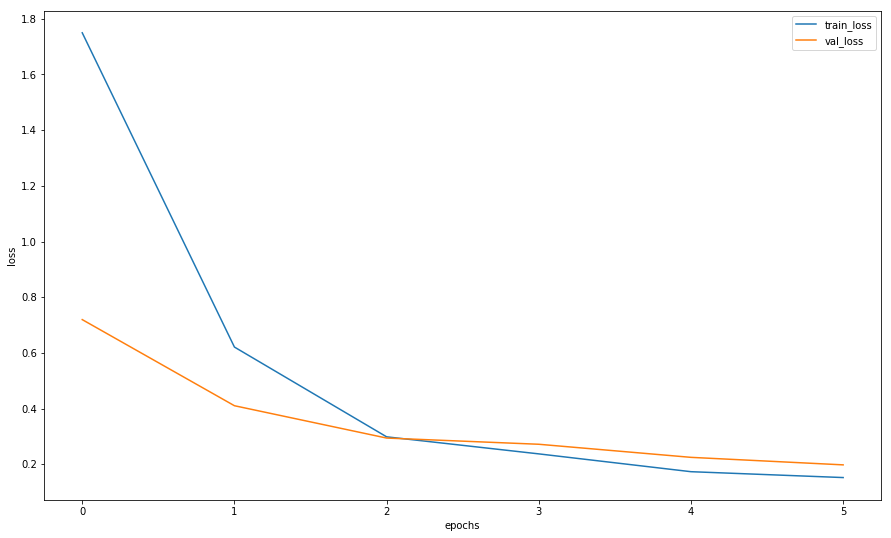

In [44]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [45]:
# Код ниже позволяет посмотреть, какире из классов плохо распознались
# Для таких классов принял решение размножить датасет
# Таким образом при применении рандомных трансформаций при загурзке, получили расширенный датасет
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model):
    """Построить и посчитать точность классов по confusion matrix"""
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all
  
def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]
    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [87]:
BATCH_SIZE = 128
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

Normalized confusion matrix


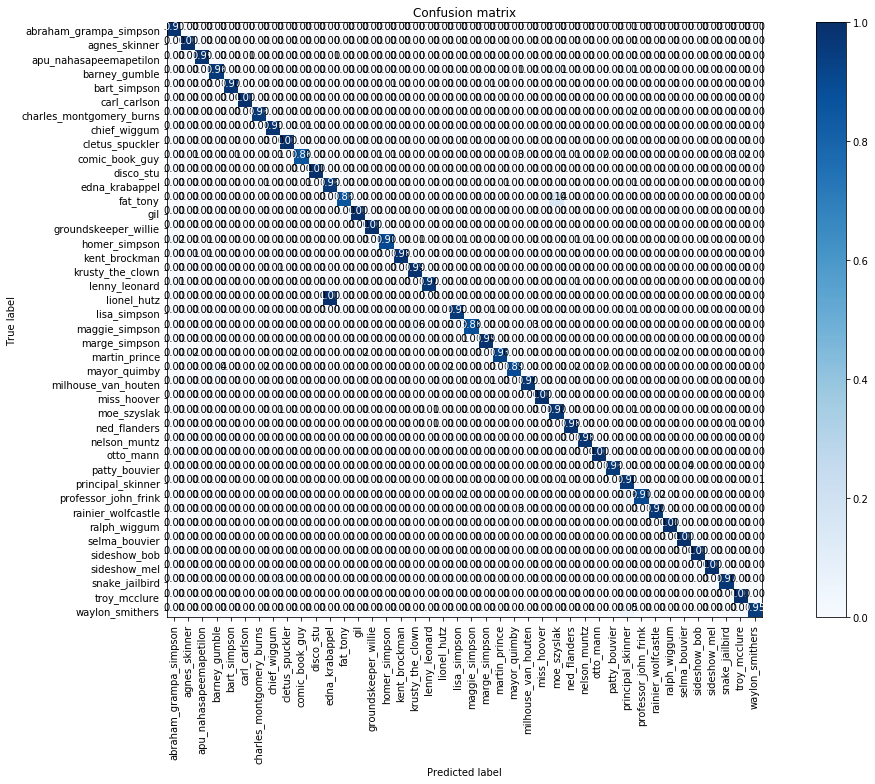

In [88]:
# %%capture
y_test_all, predictions_all = show_confusion_matrix_fucn(simple_cnn)

In [89]:
accurancy_for_each_class(y_test_all, predictions_all)

[218, 5, 153, 78, 340, 72, 304, 242, 10, 132, 6, 113, 7, 19, 25, 616, 125, 295, 73, 1, 341, 34, 318, 56, 56, 274, 13, 361, 358, 268, 20, 56, 286, 54, 34, 19, 75, 217, 30, 35, 4, 43]
42
Accuracy of abraham_grampa_simpson : 97 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 98 %
Accuracy of barney_gumble : 96 %
Accuracy of bart_simpson : 97 %
Accuracy of carl_carlson : 100 %
Accuracy of charles_montgomery_burns : 96 %
Accuracy of chief_wiggum : 98 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 85 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 96 %
Accuracy of fat_tony : 85 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 100 %
Accuracy of homer_simpson : 89 %
Accuracy of kent_brockman : 98 %
Accuracy of krusty_the_clown : 98 %
Accuracy of lenny_leonard : 97 %
Accuracy of lionel_hutz :  0 %
Accuracy of lisa_simpson : 95 %
Accuracy of maggie_simpson : 88 %
Accuracy of marge_simpson : 98 %
Accuracy of martin_prince : 9

In [29]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [30]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [31]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [39]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [33]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [35]:
from sklearn.metrics import f1_score
# f1_score(actual_labels, preds_class, average=None)
f1_score(actual_labels, preds_class, average='micro')

1.0

/home/care1e55/progz/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


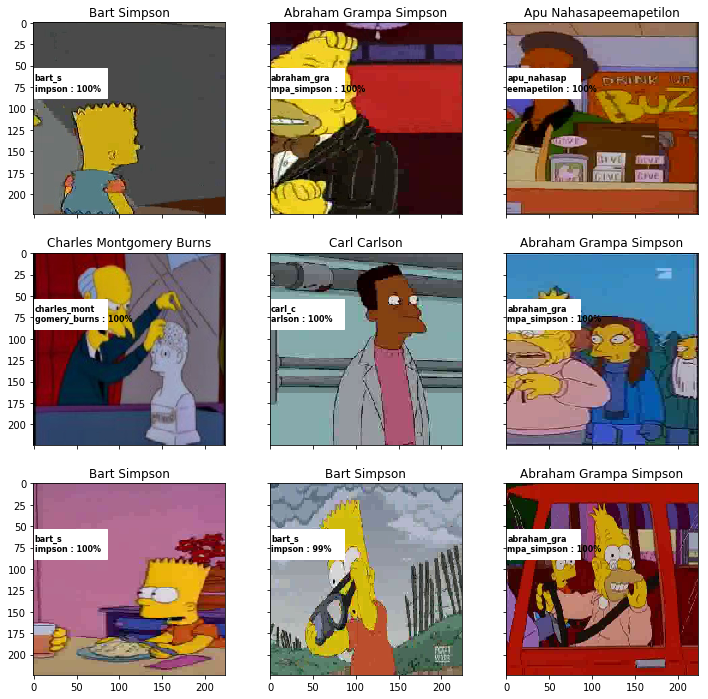

In [96]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [47]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [48]:
path = "/storage/Study/neuro/"

In [50]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv(path + '_predictresnet50_10_3.csv', index=False)